In [1]:
import os
import glob
import datetime
import importlib
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from prettytable import PrettyTable

In [2]:
import models.pbr_gpa as model # PBR + GP/A
# import models.gpa as model
#import models.ncav as model # NCAV
#import models.pbr_psr_per_pcr as model # PBR + PCR + PER + PSR
#import models.super_quality as model
#import models.lu_zhang as model
#import models.pbr as model
#import models.pcr as model
#import models.per as model
#import models.psr as model
#import models.pbr_psr as model
#import models.psr_sales_growth as model
# import models.pbr_ob as model
#import models.pbr_oa as model
#import models.peg as model
# import models.walter_scholoss as model

importlib.reload(model)

<module 'models.pbr_gpa' from '/Users/seunghun/Documents/Documents - Seunghun’s MacBook Pro/Projects/backtest-playground/quantitative-value/models/pbr_gpa.py'>

In [3]:
#DATA_DIR = '../data/quarterly/2-5-8-11' # quarter
# DATA_DIR = '../data/half-year/2-8' # half year
DATA_DIR = '../data/yearly/11-1'
REBALANCE = 1 # 1: yearly, 2: half-yearly 4: quarterly

In [7]:
df_account = pd.DataFrame(columns=['start_date', 'end_date', 'filepath'])
filepaths = glob.glob(DATA_DIR + "/*.csv")
filepaths = sorted(filepaths)

In [8]:
filepaths

['../data/yearly/11-1/2002-11-01.csv',
 '../data/yearly/11-1/2003-11-03.csv',
 '../data/yearly/11-1/2004-11-01.csv',
 '../data/yearly/11-1/2005-11-01.csv',
 '../data/yearly/11-1/2006-11-01.csv',
 '../data/yearly/11-1/2007-11-01.csv',
 '../data/yearly/11-1/2008-11-03.csv',
 '../data/yearly/11-1/2009-11-02.csv',
 '../data/yearly/11-1/2010-11-01.csv',
 '../data/yearly/11-1/2011-11-01.csv',
 '../data/yearly/11-1/2012-11-01.csv',
 '../data/yearly/11-1/2013-11-01.csv',
 '../data/yearly/11-1/2014-11-03.csv',
 '../data/yearly/11-1/2015-11-02.csv',
 '../data/yearly/11-1/2016-11-01.csv',
 '../data/yearly/11-1/2017-11-01.csv',
 '../data/yearly/11-1/2018-11-01.csv',
 '../data/yearly/11-1/2019-11-01.csv']

In [9]:
days = []
for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date =  os.path.basename(filepaths[i])[:-4]
        end_date =  os.path.basename(filepaths[i + 1])[:-4]
        
        day = {'start_date':start_date, 'end_date':end_date, 'filepath':filepaths[i]}
        days.append(day)

df_account = df_account.append(days)

In [10]:
df_account

,start_date,end_date,filepath
0,2002-11-01,2003-11-03,../data/yearly/11-1/2002-11-01.csv
1,2003-11-03,2004-11-01,../data/yearly/11-1/2003-11-03.csv
2,2004-11-01,2005-11-01,../data/yearly/11-1/2004-11-01.csv
3,2005-11-01,2006-11-01,../data/yearly/11-1/2005-11-01.csv
4,2006-11-01,2007-11-01,../data/yearly/11-1/2006-11-01.csv
5,2007-11-01,2008-11-03,../data/yearly/11-1/2007-11-01.csv
6,2008-11-03,2009-11-02,../data/yearly/11-1/2008-11-03.csv
7,2009-11-02,2010-11-01,../data/yearly/11-1/2009-11-02.csv
8,2010-11-01,2011-11-01,../data/yearly/11-1/2010-11-01.csv
9,2011-11-01,2012-11-01,../data/yearly/11-1/2011-11-01.csv


In [11]:
# 연도별 종목을 구한다.
df_account['stocks'] = df_account.apply(lambda x: 
                                        model.get_stocks(x.filepath, x.start_date,
                                                         min_market_cap=0.0, max_market_cap=0.2,
                                                         min_fund_rank=0.0, max_fund_rank=0.2, 
                                                         num_stocks=30, verbose=True), axis=1)

------------------------------
2002-11-01 ../data/yearly/11-1/2002-11-01.csv
전체 1402
지주사, 금융사 제외 1342
국외주식 제외 1342
가격정보 없는 기업 제외 964
2002-11-01 선정 기업 수 30
------------------------------
2003-11-03 ../data/yearly/11-1/2003-11-03.csv
전체 1491
지주사, 금융사 제외 1430
국외주식 제외 1430
가격정보 없는 기업 제외 1021
2003-11-03 선정 기업 수 30
------------------------------
2004-11-01 ../data/yearly/11-1/2004-11-01.csv
전체 1540
지주사, 금융사 제외 1477
국외주식 제외 1477
가격정보 없는 기업 제외 1071
2004-11-01 선정 기업 수 30
------------------------------
2005-11-01 ../data/yearly/11-1/2005-11-01.csv
전체 1630
지주사, 금융사 제외 1566
국외주식 제외 1565
가격정보 없는 기업 제외 1138
2005-11-01 선정 기업 수 30
------------------------------
2006-11-01 ../data/yearly/11-1/2006-11-01.csv
전체 1682
지주사, 금융사 제외 1616
국외주식 제외 1615
가격정보 없는 기업 제외 1193
2006-11-01 선정 기업 수 30
------------------------------
2007-11-01 ../data/yearly/11-1/2007-11-01.csv
전체 1765
지주사, 금융사 제외 1696
국외주식 제외 1691
가격정보 없는 기업 제외 1273
2007-11-01 선정 기업 수 30
------------------------------
2008-11-03 ../data/yearly/11-1/200

In [12]:
# 연도별 수익률을 구한다.
df_account['yield'] = 0.0
df_account['yields'] = 0.0
df_account['yields'] = df_account['yields'].astype('object')
df_account['delisted'] = 0
df_account['delisted_stocks'] = df_account['yields'].astype('object')

for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date = df_account.iloc[i].start_date
        end_date = df_account.iloc[i].end_date
        
        df_this_year = pd.read_csv(filepaths[i], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        df_next_year = pd.read_csv(filepaths[i + 1], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        
        stocks = df_account.iloc[i].stocks   
        yields = []
        
        # 종목별 수익률, 상장폐지 기업 수를 구한다.
        delisted = 0 # 상장폐지 기업 수
        delisted_stocks  = []
        for stock in stocks:
            start_price = df_this_year[df_this_year['종목코드'] == stock]['주가'].iloc[0]
            end_price = df_next_year[df_next_year['종목코드'] == stock]['주가']
            
            if len(end_price) == 0:
                end_price = 0
            else:                    
                end_price = end_price.fillna(0) 
                end_price = end_price.iloc[0]
                
            if end_price == 0: # 가격 정보가 없을 경우 상폐
                delisted += 1
                delisted_stocks.append(stock)
            
            # get yield
            yields.append(end_price / start_price)

        # stock 수익률들의 avg가 total 수익률이 된다. (동일 비중이기 때문에)
        mean_yields = statistics.mean(yields)
        df_account.at[i, 'yield'] = mean_yields
        df_account.at[i, 'yields'] = yields
        df_account.at[i, 'delisted'] = delisted
        df_account.at[i, 'delisted_stocks'] = delisted_stocks
        
        print(start_date, '~', end_date, ":", mean_yields)
        
        #break

2002-11-01 ~ 2003-11-03 : 0.9573703306041056
2003-11-03 ~ 2004-11-01 : 1.3565055805862567
2004-11-01 ~ 2005-11-01 : 2.782700282054746
2005-11-01 ~ 2006-11-01 : 1.1562540936217687
2006-11-01 ~ 2007-11-01 : 2.2374474468875123
2007-11-01 ~ 2008-11-03 : 0.5848314841783249
2008-11-03 ~ 2009-11-02 : 2.155247106979319
2009-11-02 ~ 2010-11-01 : 1.4222469987049235
2010-11-01 ~ 2011-11-01 : 1.2180356432029433
2011-11-01 ~ 2012-11-01 : 2.6845213791062217
2012-11-01 ~ 2013-11-01 : 1.0726307287813364
2013-11-01 ~ 2014-11-03 : 2.0258954668462614
2014-11-03 ~ 2015-11-02 : 1.735469253381261
2015-11-02 ~ 2016-11-01 : 1.275678861565896
2016-11-01 ~ 2017-11-01 : 1.2458558539914804
2017-11-01 ~ 2018-11-01 : 1.148950723520078
2018-11-01 ~ 2019-11-01 : 1.6524067910300466


In [13]:
df_account['total'] = df_account['yield'].cumprod()

In [14]:
df_account['cagr'] = 0.0
for i, row in enumerate(df_account.iterrows()):
    df_account.at[i, 'cagr'] = pow(row[1]['total'], 1/((i+1)/REBALANCE))

In [15]:
def get_win_rate(yield_rates):
    return sum([yield_rate > 1.0 for yield_rate in yield_rates]) / len(yield_rates)

df_account['win_rate'] = df_account.apply(lambda x: get_win_rate(x['yields']), axis=1)

In [16]:
df_account['best_corp'] = df_account.apply(lambda x: max(x['yields']), axis=1)
df_account['worst_corp'] = df_account.apply(lambda x: min(x['yields']), axis=1)

In [17]:
df_account['best_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmax(x['yields'])], axis=1)
df_account['worst_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmin(x['yields'])], axis=1)

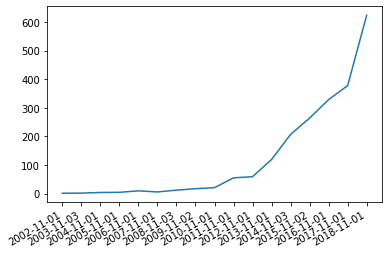

In [18]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['total'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

In [19]:
cagrs = df_account['cagr']
rolling_cagrs = []
ROLLING = 3
for i in range(len(cagrs)):
    if i - 3 < 0:
        rolling_cagr = np.mean(cagrs[0:i])
    else:
        rolling_cagr = np.mean(cagrs[i - 3:i])
    rolling_cagrs.append(rolling_cagr)

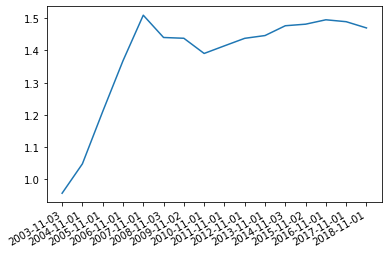

In [20]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], rolling_cagrs, marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

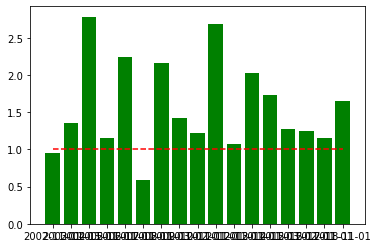

In [21]:
# fig, ax = plt.subplots()
# ax.plot_date(df_account['start_date'], df_account['yield'])
# fig.autofmt_xdate()

plt.bar(df_account['start_date'], df_account['yield'], color='green')

h_line = np.array([1.0 for i in range(len(df_account['start_date']))])
plt.plot(df_account['start_date'], h_line, 'r--') 

plt.show()

In [22]:
# 가격 정보가 없는 경우 상폐로 처리했음. 실제로 상폐까지는 아니고 거래정지인 경우가 있음
delisted_stocks = sum(df_account['delisted'])

In [23]:
cagr = pow(df_account['total'][len(df_account) - 1], 1/(len(df_account)/REBALANCE))

In [24]:
# MDD, MDD duration 구하기
max_yield = 1.0
min_yield = 1.0
mdd = 0.0
mdd_duration = 0 

dd = 0.0
dd_duration = 0
for val in df_account['total']:
    if val > max_yield:
        max_yield = val
        min_yield = val
        dd_duration = 0
        continue
    
    if val < min_yield:
        min_yield = val
        dd = (1.0 - min_yield / max_yield) * 100.0
        dd_duration += 1
        
        if dd > mdd:
            mdd = dd
        if dd_duration > mdd_duration:
            mdd_duration = dd_duration
            
if REBALANCE == 2:
    mdd_duration *= 6
elif REBALANCE == 4:
    mdd_duration *= 3

In [25]:
# 수익률 표준편차 구하기
filetered_yield = list(df_account['yield']).copy()

# outlier 제거
filetered_yield.remove(max(filetered_yield))
filetered_yield.remove(min(filetered_yield))

std_yield = statistics.stdev(filetered_yield)

In [26]:
# 평균 승률 
yields = []
for i in range(len(df_account)):
    yields.extend(df_account.iloc[i]['yields'])
    
win_rate = (sum([val > 1.0 for val in yields]) / len(yields)) * 100.0

In [27]:
t = PrettyTable(['Rebalance', 'CAGR', 'MDD', 'MDD duration', 'STD', 'Delisted', 'Win rate', 'Note'])
t.add_row([os.path.basename(DATA_DIR),
           "%.2f%%" % ((cagr - 1.0) * 100.0),
           "%.2f%%" % (mdd),
           mdd_duration,
           "%.4f" % std_yield,
           delisted_stocks,
           "%.2f%%" % win_rate,
           ""
          ])
print(t)

+-----------+--------+--------+--------------+--------+----------+----------+------+
| Rebalance |  CAGR  |  MDD   | MDD duration |  STD   | Delisted | Win rate | Note |
+-----------+--------+--------+--------------+--------+----------+----------+------+
|    11-1   | 46.02% | 41.52% |      1       | 0.5087 |    7     |  64.90%  |      |
+-----------+--------+--------+--------------+--------+----------+----------+------+


In [28]:
# 수수료 고려
df_account['fee_yield'] = df_account['yield'] * 0.99
df_account['fee_total'] = df_account['fee_yield'].cumprod()
pow(df_account['fee_total'][len(df_account) - 1], 1/(len(df_account)/REBALANCE))

1.4455795332098045

In [29]:
# N년 후 연평균 수익률 (CAGR)이 40%를 넘을 확률
yearly_yields = df_account['yield'].tolist()
cagr_threshold = 1.35

for duration in range(1, 17):
    cagrs = []
    for i, yearly_yield in enumerate(yearly_yields[:len(yearly_yields)-duration+1]):
        total_yield = np.prod(np.array(yearly_yields[i: i+duration]))
        cagr = pow(total_yield, 1/duration)
        cagrs.append(cagr)
        
    # N년 후 CAGR이 40%를 넘는 확률
    prob = sum(np.array(cagrs) > cagr_threshold) / len(cagrs)
    
    print("{:.2f}".format(prob))

0.53
0.62
0.73
0.71
1.00
0.83
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00


# 인버스 ETF로 MDD 줄이기

In [30]:
import FinanceDataReader as fdr

### inverse ETF 

- TIGER KODEX 인버스 200 (123310): 2010-03-29 ~ 
- ARIRANG KOSDAQ 150 인버스 (301410): 2018-07-11 ~

In [31]:
df_inverse_etf = fdr.DataReader('069500')

In [32]:
df_inverse_etf.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2002-10-14,5541,5683,5388,5518,2577230,NaN
2002-10-15,5578,5669,5469,5653,2288769,0.024465
2002-10-16,5713,5713,5619,5677,2039150,0.004246
2002-10-17,5669,5813,5592,5755,2091777,0.013740
2002-10-18,5898,6038,5861,6002,1321300,0.042919


In [33]:
def get_inverse_yield (x):
    index_start_price = df_inverse_etf.loc[x['start_date']]['Open']
    index_end_price = df_inverse_etf.loc[x['end_date']]['Close']
    return 1.0 + (index_end_price - index_start_price) / index_start_price

In [34]:
df_hedge = df_account[['start_date', 'end_date', 'yield']]

In [35]:
df_hedge['index_yield'] = df_hedge.apply(lambda x: get_inverse_yield(x), axis=1)
df_hedge['index_inverse_yield'] = 1 / df_hedge['index_yield']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
df_hedge['inverse_ratio'] = 0.25
df_hedge['total_yield'] = df_hedge['yield'] * (1.0 - df_hedge['inverse_ratio']) + df_hedge['index_inverse_yield'] * df_hedge['inverse_ratio']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [37]:
# 수수료 고려
df_hedge['fee_yield'] = df_hedge['yield'] * 0.99
df_hedge['fee_total'] = df_hedge['total_yield'] * 0.99

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
pow(df_hedge['fee_yield'].cumprod().iloc[len(df_hedge) - 1], 1/(len(df_account)))

1.4455795332098045

In [39]:
pow(df_hedge['fee_total'].cumprod().iloc[len(df_hedge) - 1], 1/(len(df_account)))

1.3411312272394238

In [40]:
# MDD
max_yield = 1.0
min_yield = 1.0
mdd = 0.0
mdd_duration = 0 

dd = 0.0
dd_duration = 0
for val in df_hedge['fee_total'].cumprod():
    if val > max_yield:
        max_yield = val
        min_yield = val
        dd_duration = 0
        continue
    
    if val < min_yield:
        min_yield = val
        dd = (1.0 - min_yield / max_yield) * 100.0
        dd_duration += 1
        
        if dd > mdd:
            mdd = dd
        if dd_duration > mdd_duration:
            mdd_duration = dd_duration
mdd

13.801805778020238

In [41]:
# 수익률 표준편차 구하기
filetered_yield = list(df_hedge['fee_total']).copy()

# outlier 제거
filetered_yield.remove(max(filetered_yield))
filetered_yield.remove(min(filetered_yield))

statistics.stdev(filetered_yield)

0.37617390751415986

In [42]:
# 평균 승률 
yields = []
for i in range(len(df_hedge)):
    yields.append(df_hedge.iloc[i]['fee_total'])
    
(sum([val > 1.0 for val in yields]) / len(yields)) * 100.0

88.23529411764706

In [43]:
df_hedge

,start_date,end_date,yield,index_yield,index_inverse_yield,inverse_ratio,total_yield,fee_yield,fee_total
0,2002-11-01,2003-11-03,0.957370,1.287977,0.776411,0.25,0.912131,0.947797,0.903009
1,2003-11-03,2004-11-01,1.356506,1.086587,0.920313,0.25,1.247458,1.342941,1.234983
2,2004-11-01,2005-11-01,2.782700,1.444957,0.692062,0.25,2.260041,2.754873,2.237440
3,2005-11-01,2006-11-01,1.156254,1.234690,0.809920,0.25,1.069671,1.144692,1.058974
4,2006-11-01,2007-11-01,2.237447,1.493500,0.669568,0.25,1.845478,2.215073,1.827023
5,2007-11-01,2008-11-03,0.584831,0.578616,1.728261,0.25,0.870689,0.578983,0.861982
6,2008-11-03,2009-11-02,2.155247,1.394899,0.716898,0.25,1.795660,2.133695,1.777703
7,2009-11-02,2010-11-01,1.422247,1.233089,0.810972,0.25,1.269428,1.408025,1.256734
8,2010-11-01,2011-11-01,1.218036,1.040471,0.961103,0.25,1.153803,1.205855,1.142265
9,2011-11-01,2012-11-01,2.684521,1.010380,0.989726,0.25,2.260823,2.657676,2.238214


- 2002 ~ 2019
- 매년 11/1 리밸런싱
- 모델: (PBR + GP/A) + 지수 인버스
- 인버스는 KODEX200 수익률의 역수로 가정 (지수 인버스 ETF들 중 가장 오래된 것이 2010년부터이기 떄문)

| Inverse hedge ratio |  CAGR (거래비용 1%)  |  MDD    |  STD   | 수익이 난 해 (%) | Note |
|-|-|-|-|-|-|
|    0.0    | 44.56% | 42.10%        | 0.4330     |  88.23%  |      |
|    0.2    | 36.38% | 19.46%        | 0.4013     |  88.23%  |      |
|    0.25    | 34.11% | 13.80%        | 0.3761     |  88.23%  |      |
|    0.3    | 31.75% | 10.59%        | 0.3459     |  88.23%  |      |
|    0.4    | 26.81% | 12.38%        | 0.2804     |  94.11%  |      |
|    0.5    | 21.57% | 14.17%        | 0.2213     |  76.47%  |      |
|    0.6    | 16.03% | 15.96%        | 0.1748     |  76.47%  |      |
|    0.7    | 10.18% | 17.76%        | 0.1532     |  70.58%  |      |
|    0.8    | 3.97% | 25.28%        | 0.1383    |  52.94%  |      |
|    1.0    | -9.81% | 80.29%        | 0.1481     |  17.64%  |      |